# 环境配置

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from tqdm import trange

# The multivariate Variance Gamma model basket option pricing and calibration 论文复刻

## table1

In [2]:
r = 0.03
rho = np.eye(3)
X_0 = np.array([100, 200, 300])
q = np.array([0, 0, 0])
omega = np.array([0, 0, 0])
mu = np.array([-0.1368, -0.056, -0.1984])
sigma = np.array([0.1099, 0.1677, 0.0365])
weight = np.array([1/3, 1/6, 1/9]) # w是权重，omega才是参数
K = np.array([0, 0, 0])
parameter_list = [X_0, q, omega, mu, sigma, weight, K]

table1 = pd.DataFrame(data =  {'X_0': X_0, 'mu': mu,'sigma': sigma, 'weight' : weight},
                      index =  ['stock 1', 'stock 2', 'stock 3'])
table1

,X_0,mu,sigma,weight
stock 1,100,-0.1368,0.1099,0.333333
stock 2,200,-0.0560,0.1677,0.166667
stock 3,300,-0.1984,0.0365,0.111111


## table2

### 定义函数

In [3]:
from scipy.stats import norm
import scipy.integrate as sci
import math
from scipy.stats import norm
from scipy.optimize import fsolve # 解决非线性方程组的数值求解问题
from scipy.optimize import bisect # 解决非线性方程组的数值求解问题
from scipy.stats import gamma # gamma分布的概率密度

#### upper

In [4]:
def C_upper_calculate_func(T, v, K, sigma, mu, omega, r, q):
    omega = 1/v * np.log(1 - 1/2 * (sigma ** 2) * v - mu * v)
    K_i = K / weight.copy() / len(omega)
    def f(x):
        gamma_density = gamma(a=T/v, scale=v).pdf(x) # ((1/v) ** (T/v)) / (math.gamma(T/v)) * (x ** (T/v - 1)) * np.exp(-x / v)
        d_1 = (np.log(X_0/K_i) + (r - q + omega) * T + mu * x + sigma ** 2 * x)/(sigma * np.sqrt(x))
        d_2 = d_1 - sigma * np.sqrt(x)
        exp_upper = np.exp((r - q + omega ) * T + (mu + sigma ** 2 / 2) * x)
        X_price_numerical = ((X_0 * exp_upper * norm.cdf(d_1) - K_i * norm.cdf(d_2)))
        S_price_numerical = np.dot(X_price_numerical, weight)
        return S_price_numerical * gamma_density * np.exp(-r * T)
    C_upper = sci.quad(f, 0, np.inf)[0]
    return C_upper

#### lower

In [5]:
def C_lower_calculate_func(T, v, K, sigma, mu, omega, r, q):
    def g(x):
        omega = 1/v * np.log(1 - 1/2 * (sigma ** 2) * v - mu * v)
        K_i = K / weight.copy() / len(omega)
        lambda_i = weight * X_0 * np.exp((r - q + omega) * T + (mu + sigma ** 2 / 2) * x)
        sigma2Lambda = np.dot(np.dot((lambda_i * sigma),rho),(lambda_i * sigma)) # 是个矩阵
        r_i = np.dot((lambda_i * sigma),rho)/sigma2Lambda
        gamma_density = gamma(a=T/v, scale=v).pdf(x) # ((1/v) ** (T/v)) / (math.gamma(T/v)) * (x ** (T/v - 1)) * np.exp(-x / v)
        d_1 = (np.log(X_0/K_i) + (r - q + omega) * T + mu * x + sigma ** 2 * x / 2 * (1 + r_i ** 2))/(sigma * np.sqrt(x) * r_i)
        d_2 = d_1 - sigma * np.sqrt(x) * r_i
        exp_lower = np.exp((r + omega - q) * T + (mu + sigma ** 2 / 2) * x)
        X_price_numerical = ((X_0 * exp_lower * norm.cdf(d_1) - K_i * norm.cdf(d_2)))
        S_price_numerical = np.dot(X_price_numerical, weight)
        return S_price_numerical * gamma_density * np.exp(-r * T)
    C_lower = sci.quad(g, 0, np.inf)[0]
    return C_lower

#### z_y to approximate

##### var upper

In [6]:
def var_upper_calculate_func(T, v, K, sigma, mu, omega, r, q):
    def var_upper_calculate(x):
        gamma_density = gamma(a=T/v, scale=v).pdf(x) # ((1/v) ** (T/v)) / (math.gamma(T/v)) * (x ** (T/v - 1)) * np.exp(-x / v)
        var_upper_part1 = np.outer(X_0 * weight, X_0 * weight)
        var_upper_part2 = np.exp(2 * r * T)
        var_upper_part3 = np.outer(np.exp((weight - q) * T + mu * x + sigma ** 2 / 2 * x),np.exp((weight - q) * T + mu * x + sigma ** 2 / 2 * x))
        var_upper_part4 = np.exp(np.outer(sigma,sigma) * x) - 1
        var_upper_int = sum(sum(var_upper_part1 * var_upper_part2 * var_upper_part3 * var_upper_part4))
        return var_upper_int * gamma_density
    var_upper = sci.quad(var_upper_calculate, 0, np.inf)[0]
    return var_upper

##### var lower 

In [7]:
def var_lower_calculate_func(T, v, K, sigma, mu, omega, r, q):
    def var_lower_calculation(x):
        lambda_i = weight * X_0 * np.exp((r - q + omega) * T + (mu + sigma ** 2 / 2) * x)
        sigma2Lambda = np.dot(np.dot((lambda_i * sigma),rho),(lambda_i * sigma)) # 是个矩阵
        r_i = np.dot((lambda_i * sigma),rho)/np.sqrt(sigma2Lambda)
        gamma_density = gamma(a=T/v, scale=v).pdf(x) # ((1/v) ** (T/v)) / (math.gamma(T/v)) * (x ** (T/v - 1)) * np.exp(-x / v)
        var_lower_part1 = np.outer(X_0 * weight, X_0 * weight)
        var_lower_part2 = np.exp(2 * r * T)
        var_lower_part3 = np.outer(np.exp((weight - q) * T + mu * x + sigma ** 2 / 2 * x),np.exp((weight - q) * T + mu * x + sigma ** 2 / 2 * x))
        var_lower_part4 = np.exp(np.outer(sigma * r_i, sigma * r_i) * x) - 1
        var_lower_int = sum(sum(var_lower_part1 * var_lower_part2 * var_lower_part3 * var_lower_part4))
        return var_lower_int * gamma_density
    var_lower = sci.quad(var_lower_calculation, 0, np.inf)[0]
    return var_lower

##### var Sy

In [8]:
def var_Sy_calculate_func(T, v, K, sigma, mu, omega, r, q):
    def var_calculation(x):
        gamma_density = gamma(a=T/v, scale=v).pdf(x) # ((1/v) ** (T/v)) / (math.gamma(T/v)) * (x ** (T/v - 1)) * np.exp(-x / v)
        var_part1 = np.outer(X_0 * weight, X_0 * weight)
        var_part2 = np.exp(2 * r * T)
        var_part3 = np.outer(np.exp((weight - q) * T + mu * x),np.exp((weight - q) * T + mu * x))
        var_part4_i_ne_j = np.exp((sigma ** 2 + (sigma ** 2).reshape(len(sigma),-1) + np.outer(sigma, sigma) * rho) * 2 * (1 - rho ** 2) * x/(4 - rho ** 2))
        np.fill_diagonal(var_part4_i_ne_j, np.outer(np.exp(x * sigma ** 2), np.exp(x * sigma ** 2))) # 生成E[XY] # TODO
        var_part4 = var_part4_i_ne_j - np.outer(np.exp(sigma ** 2 / 2 * x), np.exp(sigma ** 2 / 2 * x))
        # var_part4 = (np.exp((sigma ** 2) * 2 * (1 - rho ** 2) * x/(4 - rho ** 2))) * (np.exp((sigma ** 2) * 2 * (1 - rho ** 2) * x/(4 - rho ** 2))) #* np.exp(np.outer(sigma,sigma) * rho  * 2 * (1 - rho ** 2) * x/(4 - rho ** 2))
        var_int = sum(sum(var_part1 * var_part2 * var_part3 * var_part4))
        return var_int * gamma_density
    var_Sy = sci.quad(var_calculation, 0, np.inf)[0]
    return var_Sy

In [9]:
def C_approximate_calculate_func(T, v, K, sigma, mu, omega, r, q):
    C_upper = C_upper_calculate_func(T, v, K, sigma, mu, omega, r, q)
    C_lower = C_lower_calculate_func(T, v, K, sigma, mu, omega, r, q)
    var_upper = var_upper_calculate_func(T, v, K, sigma, mu, omega, r, q)
    var_lower = var_lower_calculate_func(T, v, K, sigma, mu, omega, r, q)
    var_Sy = var_Sy_calculate_func(T, v, K, sigma, mu, omega, r, q)
    z_y = (var_upper - var_Sy)/(var_upper - var_lower)
    C_approximate = z_y * C_lower + (1-z_y) * C_upper
    return C_approximate

#### sim

##### 生成随机数

##### 蒙特卡洛（向量化，指令并行）

In [10]:
from tqdm import tqdm
def monte_carlo_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num = 6):
    sim_times = 10 ** power_num
    np.random.seed(20240321) 
    Normal_values = multivariate_normal.rvs(mean=[0,0,0], cov=rho, size=sim_times)
    Gamma_values = np.random.gamma(shape = T/v, scale = v, size=sim_times)
    omega = 1/v * np.log(1 - 1/2 * (sigma ** 2) * v - mu * v)
    K_i = K / weight.copy() / len(omega)
    X_price_vector = X_0 * np.exp((r - q + omega) * T) * np.exp(np.outer(mu, Gamma_values)).T * np.exp(sigma * np.sqrt(Gamma_values.reshape(-1, 1)) * Normal_values)
    S_price_vector = np.dot(X_price_vector, weight)
    C_sim_vector_list = (S_price_vector - K) * (S_price_vector - K > 0)
    C_sim = sum(C_sim_vector_list) * np.exp(-r * T) / len(C_sim_vector_list) # 原论文是27.3230
    return C_sim

### 带入参数

In [11]:
# 表头
from itertools import product
# T, v, K, C_hat, C_sim, vare

T = [1, 2]
v = [0.5, 0.75, 0.9]
K = [75, 90, 100, 110, 125]

table2 = pd.DataFrame(list(product(T, v, K)), columns = ['T', 'v', 'K']).set_index(['T','v', 'K'])
table2.T

Empty DataFrame
Columns: [(1, 0.5, 75), (1, 0.5, 90), (1, 0.5, 100), (1, 0.5, 110), (1, 0.5, 125), (1, 0.75, 75), (1, 0.75, 90), (1, 0.75, 100), (1, 0.75, 110), (1, 0.75, 125), (1, 0.9, 75), (1, 0.9, 90), (1, 0.9, 100), (1, 0.9, 110), (1, 0.9, 125), (2, 0.5, 75), (2, 0.5, 90), (2, 0.5, 100), (2, 0.5, 110), (2, 0.5, 125), (2, 0.75, 75), (2, 0.75, 90), (2, 0.75, 100), (2, 0.75, 110), (2, 0.75, 125), (2, 0.9, 75), (2, 0.9, 90), (2, 0.9, 100), (2, 0.9, 110), (2, 0.9, 125)]
Index: []

[0 rows x 30 columns]

In [12]:
r = 0.03
rho = np.eye(3)
X_0 = np.array([100, 200, 300])
q = np.array([0, 0, 0])
mu = np.array([-0.1368, -0.056, -0.1984])
sigma = np.array([0.1099, 0.1677, 0.0365])
weight = np.array([1/3, 1/6, 1/9]) # w是权重，omega才是参数

In [13]:
from tqdm import tqdm
C_sim_result_list = list()
C_approximate_list = list()
power_num = 6

for (T,v,K) in tqdm(table2.index.values):
    C_approximate = C_approximate_calculate_func(T, v, K, sigma, mu, omega, r, q)
    C_approximate_list.append(C_approximate)
    
    C_sim = monte_carlo_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num)
    C_sim_result_list.append(C_sim)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


In [14]:
table2.loc[:,'$\overline{C}[K]$'] = C_approximate_list
table2.loc[:,'$C^sim[K]$'] = C_sim_result_list
table2.loc[:,r'$\varepsilon[K]$'] = abs(table2.loc[:,'$\overline{C}[K]$'] - table2.loc[:,'$C^sim[K]$'])/ C_sim_result_list
table2 = table2.round(4)
table2

$\overline{C}[K]$  $C^sim[K]$  $\varepsilon[K]$
T v    K                                                   
1 0.50 75             27.2845     27.3116            0.0010
       90             13.1903     13.5774            0.0285
       100             4.8647      5.9578            0.1835
       110             0.5492      1.2027            0.5434
       125            -0.0677      0.0060           12.2367
  0.75 75             27.4203     27.4386            0.0007
       90             13.5908     13.9589            0.0264
       100             5.4553      6.4220            0.1505
       110             0.8800      1.3957            0.3695
       125            -0.0679      0.0051           14.2579
  0.90 75             27.5124     27.5319            0.0007
       90             13.8037     14.1706            0.0259
       100             5.7376      6.6586            0.1383
       110             1.0376      1.4925            0.3048
       125            -0.0679      0.0048           15.0213
2 0.50 75             29.5033     29.6091            0.0036
       90             16.0197     16.6890            0.0401
       100             7.9981      9.4982            0.1579
       110             2.4371      4.2383            0.4250
       125             0.1256      0.5537            0.7731
  0.75 75             29.7503     29.8354            0.0029
       90             16.6155     17.2421            0.0363
       100             8.8488     10.1977            0.1323
       110             3.2439      4.8520            0.3314
       125             0.4249      0.7026            0.3952
  0.90 75             29.9089     29.9823            0.0024
       90             16.9335     17.5383            0.0345
       100             9.2696     10.5484            0.1212
       110             3.6353      5.1560            0.2949
       125             0.5860      0.7811            0.2498

## figure 1

### 试试逼近

#### 函数定义

In [15]:
import sys
sys.path.append('./Users/zyz/Library/CloudStorage/OneDrive-uibe.edu.cn/Code/Python/mypackage')
from mypackage.my_plot import my_plot

In [16]:
def second_derivative_approx_calculation_func(T, v, K, sigma, mu, omega, r, q, power_num, h, cal_func):
    K_plus_h = K + h
    K_minus_h = K - h
    C_sim_at_K_plus_h = cal_func(T, v, K_plus_h, sigma, mu, omega, r, q)
    C_sim_at_K_minus_h = cal_func(T, v, K_minus_h, sigma, mu, omega, r, q)
    C_sim_at_K = cal_func(T, v, K, sigma, mu, omega, r, q)

    second_derivative_approx = (C_sim_at_K_plus_h - 2*C_sim_at_K + C_sim_at_K_minus_h) / (h ** 2)
    return second_derivative_approx

#### figure的函数

In [17]:
def figure_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num, approx_num = 200, h_times = 2, plot_name = ['sigma1 = 0.1', '1-1']):
    second_derivative_approx_list1 = list()
    second_derivative_approx_list2 = list()
    power_num = 6
    sigma[0] = 0.1
    h = (np.linspace(70,130,approx_num)[1] - np.linspace(70,130,approx_num)[0]) * h_times

    for K in tqdm(np.linspace(70,130,approx_num)):
        second_derivative_approx1 = second_derivative_approx_calculation_func(T, v, K, sigma, mu, omega, r, q, power_num, h, C_approximate_calculate_func)
        second_derivative_approx2 = second_derivative_approx_calculation_func(T, v, K, sigma, mu, omega, r, q, power_num, h, monte_carlo_calculate_func)
        second_derivative_approx_list1.append(second_derivative_approx1)
        second_derivative_approx_list2.append(second_derivative_approx2)
    plot_df = pd.DataFrame(index = np.linspace(70,130,approx_num))
    plot_df['Approximate density'] = second_derivative_approx_list1
    plot_df['Empirical density'] = second_derivative_approx_list2
    my_plot(plot_df, [f'Probability distribution function {plot_name[0]}', 'Basket terminal value', '', f'figure{plot_name[1]}']).line_plot()
    return plot_df

#### 模拟

approx_num最好大于40  
h_times如果太小就容易有很大波动  
h_times理论上和approx_num一起加  

In [18]:
T, v, sigma, mu, power_num = 1, 0.7514, np.array([0.1099, 0.1677, 0.0365]), np.array([-0.1368, -0.056, -0.1984]), 6
approx_num, h_times = 60, 8

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 762.74it/s]


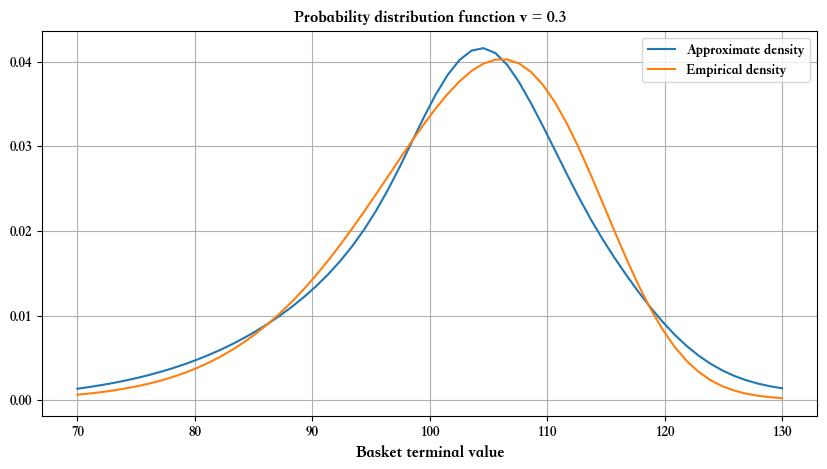

In [19]:
v = 0.3
plot_df = figure_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num, approx_num, h_times,
                                plot_name = ['v = 0.3', '1-1'])

100%|██████████| 2/2 [00:00<00:00, 2005.88it/s]


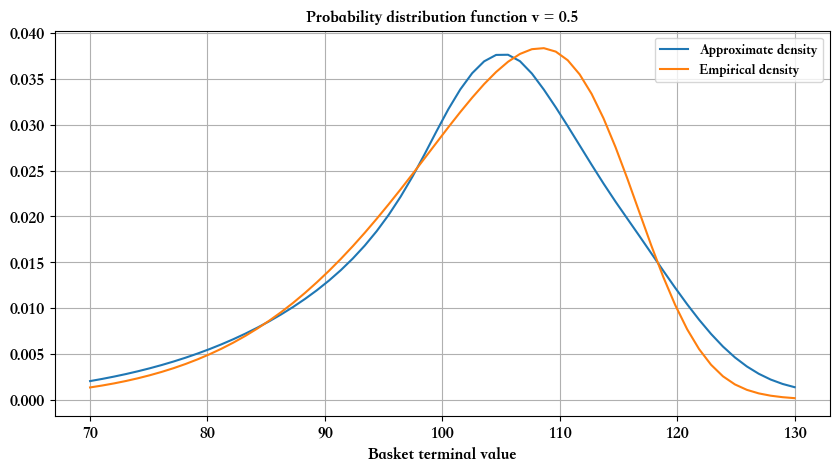

In [20]:
v = 0.5
plot_df = figure_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num, approx_num, h_times,
                                plot_name = ['v = 0.5', '1-2'])

100%|██████████| 2/2 [00:00<00:00, 2163.69it/s]


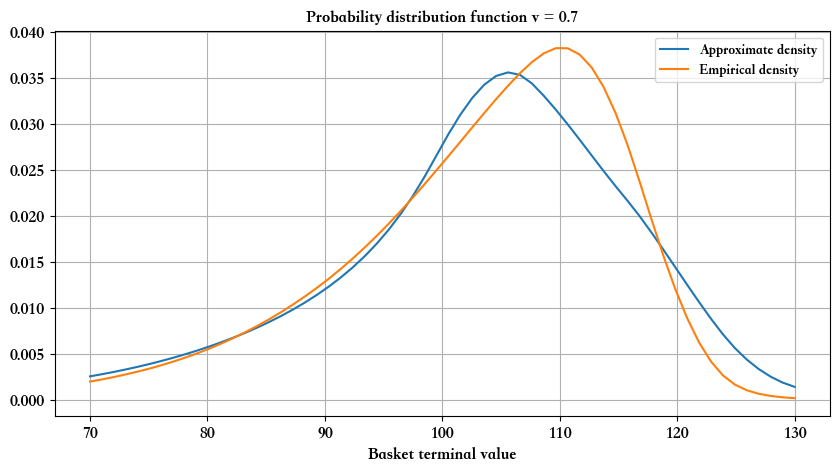

In [21]:
v = 0.7
plot_df = figure_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num, approx_num, h_times,
                                plot_name = ['v = 0.7', '1-3'])

100%|██████████| 2/2 [00:00<00:00, 1768.26it/s]


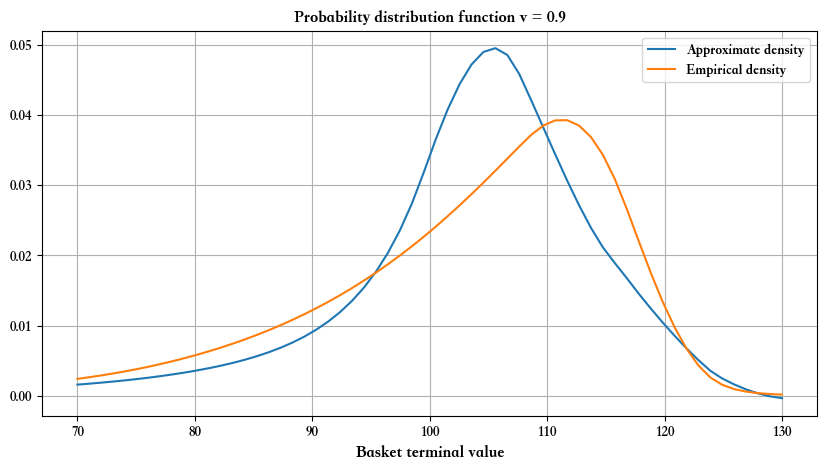

In [19]:
v = 0.9
plot_df = figure_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num, approx_num, h_times,
                                plot_name = ['v = 0.9', '1-4'])

## Figure 3

Relative error for different choices of sigma 1

In [34]:
r = 0.03
rho = np.eye(3)
X_0 = np.array([100, 200, 300])
q = np.array([0, 0, 0])
mu = np.array([-0.1368, -0.056, -0.1984])
sigma = np.array([0.1099, 0.1677, 0.0365])
weight = np.array([1/3, 1/6, 1/9]) # w是权重，omega才是参数
T = 1
K = 100

In [39]:
varepsilon_list = list()
sim_times = 100
for sigma_1 in tqdm(np.linspace(0.1,1,sim_times)):
    sigma[0] = sigma_1
    C_approximate = C_approximate_calculate_func(T, v, K, sigma, mu, omega, r, q)
    C_approximate_list.append(C_approximate)
    
    C_sim = monte_carlo_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num)
    C_sim_result_list.append(C_sim)
    
    varepsilon = abs(C_approximate - C_sim)/ C_sim
    varepsilon_list.append(varepsilon)

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:27<01:33,  1.22s/it]/Users/zyz/opt/anaconda3/lib/python3.9/site-packages/numpy/core/numeric.py:943: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/var/folders/dc/5hscf4cj45767ypphg15zwd80000gn/T/ipykernel_1706/572520665.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  var_Sy = sci.quad(var_calculation, 0, np.inf)[0]
 37%|███▋      | 37/100 [00:49<01:40,  1.59s/it]/var/folders/dc/5hscf4cj45767ypphg15zwd80000gn/T/ipykernel_1706/3748414226.py:7: RuntimeWarning: overflow encountered in exp
  var_upper_part4 = np.exp(np.outer(sigma,sigma) * x) - 1
/var/folders/dc/5hscf4cj45767ypphg15zwd80000gn/T/ipykernel_1706/3748414226.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may

100%|██████████| 1/1 [00:00<00:00, 1400.44it/s]


,varepsilon
0.000000,0.153803
0.010101,0.139556
0.020202,0.125666
0.030303,0.111919
0.040404,0.098139
...,...
0.959596,NaN
0.969697,NaN
0.979798,NaN
0.989899,NaN


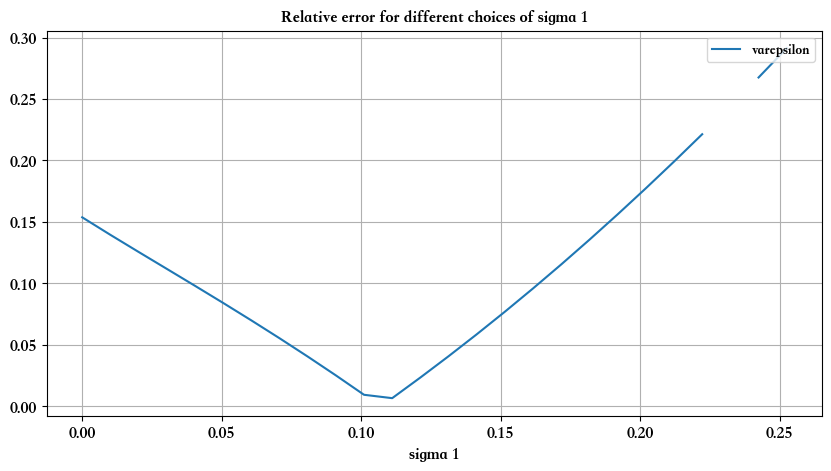

In [42]:
plot_df_varepsilon = pd.DataFrame(index = np.linspace(0,1,sim_times))
plot_df_varepsilon['varepsilon'] = varepsilon_list
my_plot(plot_df_varepsilon, [f'Relative error for different choices of sigma 1', 'sigma 1', '', f'figure 3']).line_plot()
plot_df_varepsilon

## table 3

### 带入参数

In [23]:
v = 0.7514
r = 0.03
rho = np.eye(3)
X_0 = np.array([100, 200, 300])
q = np.array([0, 0, 0])
mu = np.array([-0.1368, -0.056, -0.1984])
sigma = np.array([0.1099, 0.1677, 0.0365])
weight = np.array([1/3, 1/6, 1/9]) # w是权重，omega才是参数

In [24]:
# 表头
from itertools import product
# T, v, K, C_hat, C_sim, vare

T = [1, 2]
sigma_1 = [0.05, 0.25, 0.75]
K = [75, 90, 100, 110, 125]

table3 = pd.DataFrame(list(product(T, sigma_1, K)), columns = ['T', 'sigma_1', 'K']).set_index(['T','sigma_1', 'K'])
table3.T

Empty DataFrame
Columns: [(1, 0.05, 75), (1, 0.05, 90), (1, 0.05, 100), (1, 0.05, 110), (1, 0.05, 125), (1, 0.25, 75), (1, 0.25, 90), (1, 0.25, 100), (1, 0.25, 110), (1, 0.25, 125), (1, 0.75, 75), (1, 0.75, 90), (1, 0.75, 100), (1, 0.75, 110), (1, 0.75, 125), (2, 0.05, 75), (2, 0.05, 90), (2, 0.05, 100), (2, 0.05, 110), (2, 0.05, 125), (2, 0.25, 75), (2, 0.25, 90), (2, 0.25, 100), (2, 0.25, 110), (2, 0.25, 125), (2, 0.75, 75), (2, 0.75, 90), (2, 0.75, 100), (2, 0.75, 110), (2, 0.75, 125)]
Index: []

[0 rows x 30 columns]

In [ ]:
from tqdm import tqdm
C_sim_result_list = list()
C_approximate_list = list()
power_num = 6

for (T,sigma_1,K) in tqdm(table3.index.values):
    sigma[0] = sigma_1
    C_approximate = C_approximate_calculate_func(T, v, K, sigma, mu, omega, r, q)
    C_approximate_list.append(C_approximate)
    
    C_sim = monte_carlo_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num)
    C_sim_result_list.append(C_sim)

In [189]:
table3.loc[:,'$\overline{C}[K]$'] = C_approximate_list
table3.loc[:,'$C^sim[K]$'] = C_sim_result_list
table3.loc[:,r'$\varepsilon[K]$'] = abs(table3.loc[:,'$\overline{C}[K]$'] - table3.loc[:,'$C^sim[K]$'])/ C_sim_result_list
table3 = table3.round(4)
table3

$\overline{C}[K]$  $C^sim[K]$  $\varepsilon[K]$
T sigma_1 K                                                   
1 0.05    75             27.5248     27.4120            0.0041
          90             14.0014     13.8910            0.0080
          100             6.2472      6.3187            0.0113
          110             1.5321      1.2940            0.1840
          125             0.0771      0.0025           30.2324
  0.25    75             28.6649     27.5413            0.0408
          90             17.0361     14.3012            0.1912
          100            11.0923      6.9839            0.5883
          110             6.1862      2.0269            2.0520
          125             1.9684      0.1130           16.4206
  0.75    75                 NaN     28.2643               NaN
          90                 NaN     16.6545               NaN
          100                NaN     11.0177               NaN
          110                NaN      7.4800               NaN
          125                NaN      4.8678               NaN
2 0.05    75             29.9794     29.7944            0.0062
          90             17.3049     17.1358            0.0099
          100            10.0071     10.0451            0.0038
          110             4.6077      4.6827            0.0160
          125             1.0906      0.6021            0.8113
  0.25    75             32.2049     30.0484            0.0718
          90             22.1474     17.7785            0.2457
          100            16.9901     10.9853            0.5466
          110            12.5979      5.7972            1.1731
          125             6.6246      1.4419            3.5944
  0.75    75                 NaN     31.3860               NaN
          90                 NaN     21.2675               NaN
          100                NaN     16.3827               NaN
          110                NaN     12.9346               NaN
          125                NaN      9.7102               NaN

# bak

## 换逻辑前，list然后append然后整体运算

In [130]:
from tqdm import tqdm
C_upper_lst = list()
C_lower_lst = list()
var_upper_lst = list()
var_lower_lst = list()
var_Sy_lst = list()
C_sim_list = list()
C_sim_result_list = list()
power_num = 6

for (T,v,K) in tqdm(table2.index.values):
    C_upper = C_upper_calculate_func(T, v, K, sigma, mu, omega, r, q)
    C_upper_lst.append(C_upper)
    C_lower = C_lower_calculate_func(T, v, K, sigma, mu, omega, r, q)
    C_lower_lst.append(C_lower)
    var_upper = var_upper_calculate_func(T, v, K, sigma, mu, omega, r, q)
    var_upper_lst.append(var_upper)
    var_lower = var_lower_calculate_func(T, v, K, sigma, mu, omega, r, q)
    var_lower_lst.append(var_lower)
    var_Sy = var_Sy_calculate_func(T, v, K, sigma, mu, omega, r, q)
    var_Sy_lst.append(var_Sy)
    C_sim = monte_carlo_calculate_func(T, v, K, sigma, mu, omega, r, q, power_num)
    C_sim_result_list.append(C_sim)
    z_y = (np.array(var_upper_lst) - np.array(var_Sy_lst))/(np.array(var_upper_lst) - np.array(var_lower_lst))
    C_approximate = z_y * C_lower_lst + (1-z_y) * C_upper_lst
    
table2.loc[:,'$\overline{C}[K]$'] = C_approximate
table2.loc[:,'$C^sim[K]$'] = C_sim_result_list
table2.loc[:,r'$\varepsilon[K]$'] = abs(table2.loc[:,'$\overline{C}[K]$'] - table2.loc[:,'$C^sim[K]$'])/ table2.loc[:,'$C^sim[K]$']
table2.loc[:,'$C^u$'] = C_upper_lst
table2.loc[:,'$C^l$'] = C_lower_lst
table2.loc[:,'$Var^u$'] = var_upper_lst
table2.loc[:,'$Var^l$'] = var_lower_lst
table2.loc[:,'$Var[Sy]$'] = var_Sy_lst
table2.loc[:,'$z_y$'] = (table2.loc[:,'$Var^u$'] - table2.loc[:,'$Var[Sy]$'])/(table2.loc[:,'$Var^u$'] - table2.loc[:,'$Var^l$'] )
table2.loc[:,'$\overline{C}[K]$'] = table2.loc[:,'$z_y$'] * table2.loc[:,'$C^l$'] + (1-table2.loc[:,'$z_y$']) * table2.loc[:,'$C^u$']
table2 = table2.round(4)
table2.to_clipboard()
table2

100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


$\overline{C}[K]$  $C^sim[K]$  $\varepsilon[K]$    $C^u$    $C^l$  \
T v    K                                                                        
1 0.50 75             27.4591     27.3116            0.0054  27.5449  27.3232   
       90             14.0228     13.5774            0.0328  14.4322  13.3746   
       100             6.5479      5.9578            0.0990   7.3757   5.2373   
       110             1.9861      1.2027            0.6513   2.6928   0.8673   
       125             0.2383      0.0060           38.5212   0.3888   0.0000   
  0.75 75             27.6453     27.4386            0.0075  27.7540  27.4721   
       90             14.4322     13.9589            0.0339  14.8389  13.7845   
       100             7.0164      6.4220            0.0926   7.7711   5.8148   
       110             2.2323      1.3957            0.5994   2.8860   1.1914   
       125             0.2268      0.0051           43.3179   0.3693   0.0000   
  0.90 75             27.7607     27.5319            0.0083  27.8794  27.5708   
       90             14.6447     14.1706            0.0335  15.0469  14.0015   
       100             7.2406      6.6586            0.0874   7.9595   6.0911   
       110             2.3457      1.4925            0.5717   2.9714   1.3453   
       125             0.2209      0.0048           44.6018   0.3591   0.0000   
2 0.50 75             29.9060     29.6091            0.0100  30.0965  29.5989   
       90             17.3836     16.6890            0.0416  18.0287  16.3435   
       100            10.3538      9.4982            0.0901  11.4680   8.5573   
       110             5.1991      4.2383            0.2267   6.5056   3.0927   
       125             1.5181      0.5537            1.7416   2.1768   0.4562   
  0.75 75             30.2213     29.8354            0.0129  30.4404  29.8647   
       90             17.9767     17.2421            0.0426  18.6099  16.9462   
       100            11.0685     10.1977            0.0854  12.1011   9.3881   
       110             5.8435      4.8520            0.2043   7.0529   3.8755   
       125             1.7890      0.7026            1.5463   2.4236   0.7564   
  0.90 75             30.4100     29.9823            0.0143  30.6407  30.0322   
       90             18.2880     17.5383            0.0427  18.9119  17.2668   
       100            11.4233     10.5484            0.0829  12.4153   9.7996   
       110             6.1567      5.1560            0.1941   7.3180   4.2558   
       125             1.9286      0.7811            1.4689   2.5470   0.9164   

             $Var^u$   $Var^l$  $Var[Sy]$   $z_y$  
T v    K                                           
1 0.50 75   141.9349   61.6955   110.8710  0.3871  
       90   141.9349   61.6955   110.8710  0.3871  
       100  141.9349   61.6955   110.8710  0.3871  
       110  141.9349   61.6955   110.8710  0.3871  
       125  141.9349   61.6955   110.8710  0.3871  
  0.75 75   137.2473   60.0178   107.4557  0.3858  
       90   137.2473   60.0178   107.4557  0.3858  
       100  137.2473   60.0178   107.4557  0.3858  
       110  137.2473   60.0178   107.4557  0.3858  
       125  137.2473   60.0178   107.4557  0.3858  
  0.90 75   134.6077   59.0705   105.5446  0.3848  
       90   134.6077   59.0705   105.5446  0.3848  
       100  134.6077   59.0705   105.5446  0.3848  
       110  134.6077   59.0705   105.5446  0.3848  
       125  134.6077   59.0705   105.5446  0.3848  
2 0.50 75   403.7162  176.9861   316.9234  0.3828  
       90   403.7162  176.9861   316.9234  0.3828  
       100  403.7162  176.9861   316.9234  0.3828  
       110  403.7162  176.9861   316.9234  0.3828  
       125  403.7162  176.9861   316.9234  0.3828  
  0.75 75   391.8035  172.5670   308.3564  0.3806  
       90   391.8035  172.5670   308.3564  0.3806  
       100  391.8035  172.5670   308.3564  0.3806  
       110  391.8035  172.5670   308.3564  0.3806  
       125  391.8035  172.5670   308.3564  0.3806  
  0.90 75   385

## pytorch求二阶导的尝试（最后用数值逼近了）

### 原版

In [ ]:
import torch
power_num = 6
T = 1
v = 0.5
K = 75
r = 0.03
rho = np.eye(3)
X_0 = np.array([100, 200, 300])
q = np.array([0, 0, 0])
omega = np.array([0, 0, 0])
mu = np.array([-0.1368, -0.056, -0.1984])
sigma = np.array([0.1099, 0.1677, 0.0365])
weight = np.array([1/3, 1/6, 1/9])

sim_times = 10 ** power_num
np.random.seed(20240321) 
Normal_values = multivariate_normal.rvs(mean=[0,0,0], cov=rho, size=sim_times)
Gamma_values = np.random.gamma(shape = T/v, scale = v, size=sim_times)
omega = 1/v * np.log(1 - 1/2 * (sigma ** 2) * v - mu * v)
K_i = K / weight.copy() / len(omega)
X_price_vector = X_0 * np.exp((r - q + omega) * T) * np.exp(np.outer(mu, Gamma_values)).T * np.exp(sigma * np.sqrt(Gamma_values.reshape(-1, 1)) * Normal_values)
S_price_vector = np.dot(X_price_vector, weight)
C_sim = np.dot((S_price_vector - K), (S_price_vector - K > 0)) / len(S_price_vector)* np.exp(-r * T)
# C_sim.backward()
# K.grad
C_sim
# S_price_vector

27.311555547643277

### pytorch

In [26]:
import torch
import numpy as np
from scipy.stats import multivariate_normal
power_num = 6

T = torch.tensor(1., dtype=torch.float64)
v = torch.tensor(0.5, dtype=torch.float64)
K = torch.tensor(75., requires_grad=True, dtype=torch.float64)
r = torch.tensor(0.03, dtype=torch.float64)
rho = torch.eye(3, dtype=torch.float64)
X_0 = torch.tensor([100., 200., 300.], dtype=torch.float64)
q = torch.tensor([0., 0., 0.], dtype=torch.float64)
omega = torch.tensor([0., 0., 0.], dtype=torch.float64)
mu = torch.tensor([-0.1368, -0.056, -0.1984], dtype=torch.float64)
sigma = torch.tensor([0.1099, 0.1677, 0.0365], dtype=torch.float64)
weight = torch.tensor([1/3, 1/6, 1/9], dtype=torch.float64)

sim_times = 10 ** power_num
np.random.seed(20240321) 
Normal_values = multivariate_normal.rvs(mean=[0,0,0], cov=rho.numpy(), size=sim_times)
Gamma_values = np.random.gamma(shape = T/v, scale = v, size=sim_times)
omega = 1/v * torch.log(1 - 1/2 * (sigma ** 2) * v - mu * v)
K_i = K / weight.clone() / len(omega)
X_price_vector = X_0 * torch.exp((r - q + omega) * T) * torch.exp(torch.tensor(np.outer(mu.numpy(), Gamma_values), dtype=torch.float64).T ) * torch.exp((sigma * np.sqrt(Gamma_values.reshape(-1, 1)) * Normal_values).clone().detach())
S_price_vector = torch.matmul(X_price_vector, weight)
C_sim = torch.mean((S_price_vector - K) * (S_price_vector - K > torch.tensor(0., dtype=torch.float64)).double()) * torch.exp(-r * T)
C_sim

tensor(27.3116, dtype=torch.float64, grad_fn=<MulBackward0>)

In [ ]:
def grad_f(x,f):
	y = f(x)
	y.backward()
	return x.grad

In [ ]:
# Now compute the second derivative
K.grad.zero_()
temp = torch.autograd.grad(C_sim, K, create_graph=True)[0]
temp.backward()
second_derivative = K.grad.item()

print(f"The first derivative is: {first_derivative}")
print(f"The second derivative is: {second_derivative}")

### 实验

In [30]:
x ** 2 
x

tensor(2., requires_grad=True)

In [37]:
import torch

# 创建一个需要求导的张量
x = torch.tensor(2.0, requires_grad=True)
z = x / torch.tensor([2.0,2.0], requires_grad=True)

# 定义一个函数 y = x^2
z = x ** 2 + x
y = x * z

import torch

# 创建一个需要求导的张量
x = torch.tensor(2.0, requires_grad=True)
z = x / torch.tensor([2.0, 2.0], requires_grad=True)

# 定义一个函数 y = x^2
z = x ** 2 + x
y = x * z

# 计算一阶导数
y.backward()

# 计算二阶导数
second_derivative = x.grad.grad

print(second_derivative)



None
